# Link to the kaggle dataset used for training. 
### (Notebook made on kaggle so all paths are based on that)
##### https://www.kaggle.com/datasets/galaxyh/kdd-cup-1999-data

### DAGMM Trained on Data Containing Anomalies. 

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Configuration
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Load and preprocess data
def load_and_preprocess_data():
    # Load dataset
    columns = [
        'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
        'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
        'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
        'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
        'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
        'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
        'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
        'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
        'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
        'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate', 'label'
    ]
    
    df = pd.read_csv('/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent_corrected', header=None, names=columns)
    
    # Create binary labels (1 for attacks, 0 for normal)
    df['label'] = df['label'].apply(lambda x: 1 if x == 'normal.' else 0)
    
    # Preprocessing
    categorical_features = ['protocol_type', 'service', 'flag']
    numerical_features = [col for col in columns if col not in categorical_features + ['label']]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_features),
            ('num', StandardScaler(), numerical_features)
        ])
    
    X = preprocessor.fit_transform(df.drop('label', axis=1))
    y = df['label'].values
    
    return X, y

In [8]:
# DAGMM Model
class DAGMM(tf.keras.Model):
    def __init__(self, input_dim, latent_dim=4, num_components=3):
        super(DAGMM, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_components = num_components
        
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(60, activation='tanh'),
            layers.Dense(30, activation='tanh'),
            layers.Dense(10, activation='tanh'),
            layers.Dense(latent_dim, activation='tanh')
        ])
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(10, activation='tanh'),
            layers.Dense(30, activation='tanh'),
            layers.Dense(60, activation='tanh'),
            layers.Dense(input_dim)
        ])
        
        # Estimation Network
        self.estimation_net = tf.keras.Sequential([
            layers.Dense(10, activation='tanh'),
            layers.Dense(num_components, activation='softmax')
        ])
        
    def call(self, inputs):
        # Compression Network
        z = self.encoder(inputs)
        x_recon = self.decoder(z)
        
        # Reconstruction Error
        rec_error = tf.norm(inputs - x_recon, axis=1, keepdims=True)
        
        # Estimation Network Input
        est_input = tf.concat([z, rec_error], axis=1)
        gamma = self.estimation_net(est_input)
        
        # Compute GMM parameters
        gamma_sum = tf.reduce_sum(gamma, axis=0)
        phi = gamma_sum / tf.cast(tf.shape(gamma)[0], tf.float32)
        
        mu = tf.einsum('nk,ni->ki', gamma, est_input) / gamma_sum[:, tf.newaxis]
        
        # Compute covariance with regularization
        diff = est_input[:, tf.newaxis, :] - mu[tf.newaxis, :, :]
        sigma = tf.einsum('nk,nki,nkj->kij', gamma, diff, diff) / gamma_sum[:, tf.newaxis, tf.newaxis]
        sigma += tf.eye(est_input.shape[1], dtype=tf.float32)[tf.newaxis, :, :] * 1e-6
        
        # Calculate energy
        inv_sigma = tf.linalg.inv(sigma)
        exponent = -0.5 * tf.einsum('nki,kij,nkj->nk', diff, inv_sigma, diff)
        log_det = tf.linalg.logdet(sigma)
        log_prob = exponent - 0.5 * log_det[tf.newaxis, :] + tf.math.log(phi)[tf.newaxis, :]
        energy = -tf.reduce_logsumexp(log_prob, axis=1)
        
        # Loss components
        rec_loss = tf.reduce_mean(tf.square(inputs - x_recon))
        energy_loss = tf.reduce_mean(energy)
        cov_penalty = tf.reduce_sum(tf.linalg.diag_part(sigma)) * 0.005
        
        self.add_loss(rec_loss + 0.1 * energy_loss + cov_penalty)
        
        return x_recon


In [9]:
# Anomaly score calculation
def calculate_energy(model, data):
    encoder = model.encoder
    decoder = model.decoder
    estimation_net = model.estimation_net
    
    z = encoder.predict(data)
    x_recon = decoder.predict(z)
    rec_error = np.linalg.norm(data - x_recon, axis=1, keepdims=True)
    est_input = np.concatenate([z, rec_error], axis=1)
    gamma = estimation_net.predict(est_input)
    
    # Compute energy
    gamma_sum = gamma.sum(axis=0)
    phi = gamma_sum / gamma.shape[0]
    mu = np.einsum('nk,ni->ki', gamma, est_input) / gamma_sum[:, np.newaxis]
    
    diff = est_input[:, np.newaxis, :] - mu[np.newaxis, :, :]
    sigma = np.einsum('nk,nki,nkj->kij', gamma, diff, diff) / gamma_sum[:, np.newaxis, np.newaxis]
    sigma += np.eye(est_input.shape[1])[np.newaxis, :, :] * 1e-6
    
    inv_sigma = np.linalg.inv(sigma)
    exponent = -0.5 * np.einsum('nki,kij,nkj->nk', diff, inv_sigma, diff)
    log_det = np.linalg.slogdet(sigma)[1]
    log_prob = exponent - 0.5 * log_det[np.newaxis, :] + np.log(phi)[np.newaxis, :]
    energy = -np.log(np.sum(np.exp(log_prob), axis=1))
    
    return energy

# Train the Model

Epoch 1/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: -0.7840 - val_loss: -2.1165
Epoch 2/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: -2.0182 - val_loss: -2.2936
Epoch 3/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: -2.1491 - val_loss: -2.3411
Epoch 4/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: -2.2002 - val_loss: -2.4409
Epoch 5/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: -2.2876 - val_loss: -2.4851
Epoch 6/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: -2.3343 - val_loss: -2.4972
Epoch 7/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: -2.3494 - val_loss: -2.5049
Epoch 8/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: -2.3564 - val_loss: -2.5105
Epoch 9/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: -2.3609 - val_loss: -2.5144
Epoch 10/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: -2.3641 - val_loss: -2.5175
Epoch 11/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: -2.3666 - val_loss: -2.5202
Epoch 12/15
348/34

/tmp/ipykernel_31/2849015788.py:26: RuntimeWarning: divide by zero encountered in log
  energy = -np.log(np.sum(np.exp(log_prob), axis=1))


3088/3088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     79452
           1       0.35      0.02      0.05     19353

    accuracy                           0.80     98805
   macro avg       0.58      0.51      0.47     98805
weighted avg       0.72      0.80      0.72     98805


Confusion Matrix:
[[78576   876]
 [18873   480]]


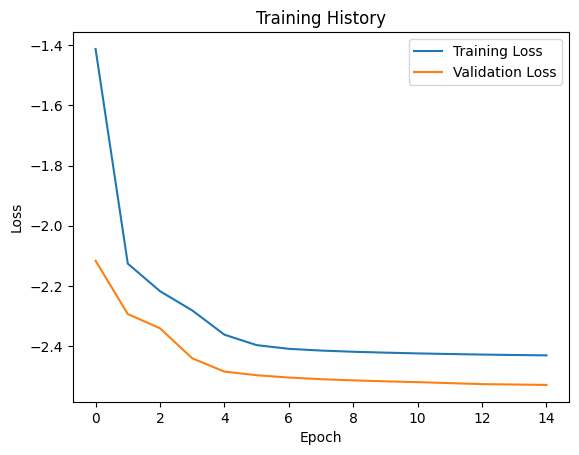

In [10]:
# Load and prepare data
X, y = load_and_preprocess_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Model parameters
input_dim = X_train.shape[1]
dagmm = DAGMM(input_dim=input_dim)
dagmm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

# Training
history = dagmm.fit(
    X_train, X_train,
    epochs=15,
    batch_size=1024,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

train_energy = calculate_energy(dagmm, X_train)
test_energy = calculate_energy(dagmm, X_test)

# Find threshold using 95th percentile of training energy
threshold = np.percentile(train_energy, 80)
predictions = (test_energy > threshold).astype(int)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
# Find threshold using arbitrary percentile of training energy
threshold = np.percentile(train_energy, 56)
predictions = (test_energy > threshold).astype(int)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.70      0.83     79452
           1       0.45      1.00      0.62     19353

    accuracy                           0.76     98805
   macro avg       0.73      0.85      0.72     98805
weighted avg       0.89      0.76      0.79     98805


Confusion Matrix:
[[55908 23544]
 [    0 19353]]


In [20]:
# Find threshold using 80th percentile of training energy
threshold = np.percentile(train_energy, 80)
predictions = (test_energy > threshold).astype(int)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     79452
           1       0.35      0.02      0.05     19353

    accuracy                           0.80     98805
   macro avg       0.58      0.51      0.47     98805
weighted avg       0.72      0.80      0.72     98805


Confusion Matrix:
[[78576   876]
 [18873   480]]


# Treshold vs percentile

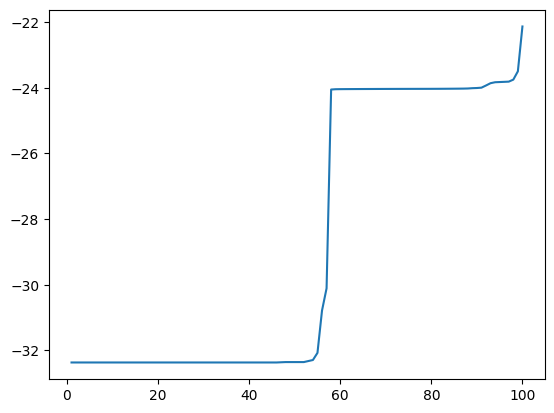

In [21]:
x = [i+1 for i in range(100)]
y = []
for i in range(100):
    y.append(np.percentile(train_energy, i))
plt.plot(x,y)

# This model uses pure data with no anomalies for training

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Configuration
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Load and preprocess data (ONLY normal samples for training)
def load_and_preprocess_data(train_on_normal_only=True):
    # Load dataset (same as before)
    columns = [
        'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
        'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
        'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
        'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
        'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
        'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
        'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
        'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
        'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
        'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate', 'label'
    ]
    
    df = pd.read_csv('/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent_corrected', header=None, names=columns)
    df['label'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)

    # Split data
    X_normal = df[df['label'] == 0].drop('label', axis=1)
    X_attack = df[df['label'] == 1].drop('label', axis=1)
    y_normal = df[df['label'] == 0]['label'].values
    y_attack = df[df['label'] == 1]['label'].values

    # Preprocessing: Handle unknown categories in OneHotEncoder
    categorical_features = ['protocol_type', 'service', 'flag']
    numerical_features = [col for col in columns if col not in categorical_features + ['label']]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),  # Fix here
            ('num', StandardScaler(), numerical_features)
        ])

    # Fit ONLY on normal data
    X_normal_processed = preprocessor.fit_transform(X_normal)
    X_attack_processed = preprocessor.transform(X_attack)  # Now ignores unknown categories

    # Combine for test set
    X_processed = np.vstack([X_normal_processed, X_attack_processed])
    y_processed = np.concatenate([y_normal, y_attack])

    # Train on normal data only
    X_train = X_normal_processed
    y_train = y_normal

    # Test set (normal + attacks)
    X_test, _, y_test, _ = train_test_split(
        X_processed, y_processed, 
        test_size=0.3, 
        random_state=RANDOM_SEED
    )
    
    return X_train, X_test, y_test

# Load data (now X_train contains ONLY normal samples)
X_train, X_test, y_test = load_and_preprocess_data(train_on_normal_only=True)

# Model parameters
input_dim = X_train.shape[1]
dagmm = DAGMM(input_dim=input_dim)
dagmm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

# Train ONLY on normal data (label=0)
history = dagmm.fit(
    X_train, X_train,  # Autoencoder learns to reconstruct normal patterns
    epochs=30,
    batch_size=1024,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0801 - val_loss: -1.7106
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: -1.5509 - val_loss: -2.0767
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: -1.8865 - val_loss: -2.1421
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: -1.9601 - val_loss: -2.1617
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: -1.9803 - val_loss: -2.1732
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: -1.9915 - val_loss: -2.1830
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: -1.9991 - val_loss: -2.1920
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: -2.0050 - val_loss: -2.2001
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: -2.0099 - val_loss: -2.2075
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: -2.0141 - val_loss: -2.2130
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: -2.0180 - val_loss: -2.2171
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 

# Evaluate on test set

In [64]:
test_energy = calculate_energy(dagmm, X_test)
threshold = np.percentile(test_energy[y_test == 0], 80)  # Threshold based on normal samples
predictions = (test_energy > threshold).astype(int)

# Classification report
print(classification_report(y_test, predictions))

10807/10807 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


/tmp/ipykernel_31/1902376486.py:168: RuntimeWarning: divide by zero encountered in log
  energy = -np.log(np.sum(np.exp(log_prob), axis=1))


              precision    recall  f1-score   support

           0       0.99      0.80      0.89     67971
           1       0.95      1.00      0.98    277843

    accuracy                           0.96    345814
   macro avg       0.97      0.90      0.93    345814
weighted avg       0.96      0.96      0.96    345814

